# Set up 

In [63]:
topology='A'
omission='reg1-stronger'

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
os.chdir('../../..')
from src import antemll, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/topologyA/all_data/')

# Perturbing enzymes

In [3]:
# generate enzyme perturbation data
Teusink_ant ='../../../models/Antimony/topologyA-reg1-stronger.ant' 
util.generate_data(Teusink_ant, [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10], '../../../data/interim/generated_data/topologyA-reg1-stronger/')

In [4]:
Teusink_ant ='../../../models/Antimony/topologyA-reg1-stronger.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.simulate(0,100)
r.steadyState()

1.034058172988248e-15

In [5]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [6]:
data_file01 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_0.1.csv'
data_file02 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_0.2.csv'
data_file03 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_0.3.csv'
data_file04 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_0.4.csv'
data_file05 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_0.5.csv'

data_file15 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_1.5.csv'
data_file3 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_3.csv'
data_file5 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_5.csv'
data_file7 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_7.csv'
data_file100 = '../../../data/interim/generated_data/TopologyA-reg1-stronger/TopologyA-reg1-stronger_10.csv'


In [7]:
BMCA_obj01 = antemll.antemll(Teusink_ant, data_file01, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj02 = antemll.antemll(Teusink_ant, data_file02, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj03 = antemll.antemll(Teusink_ant, data_file03, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj04 = antemll.antemll(Teusink_ant, data_file04, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj05 = antemll.antemll(Teusink_ant, data_file05, '../../../models/sbml/topologyA_cobra.xml')

BMCA_obj15 = antemll.antemll(Teusink_ant, data_file15, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj3 = antemll.antemll(Teusink_ant, data_file3, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj5 = antemll.antemll(Teusink_ant, data_file5, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj7 = antemll.antemll(Teusink_ant, data_file7, '../../../models/sbml/topologyA_cobra.xml')
BMCA_obj100 = antemll.antemll(Teusink_ant, data_file100, '../../../models/sbml/topologyA_cobra.xml')


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyA_cobra.ant


## Running BMCA

In [8]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 3,720.2


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,436.9


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,139.1


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,043.5


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,000.6


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 974.03


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,266.4


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,696.6


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,404


c:\Users\user\miniconda3\envs\gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4,253.2


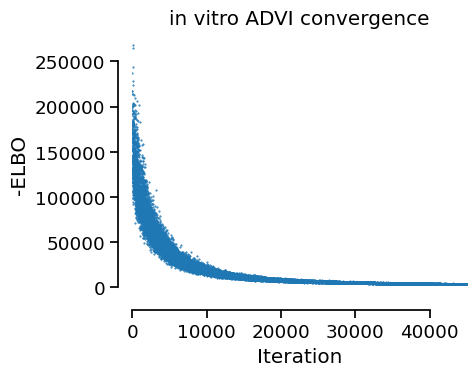

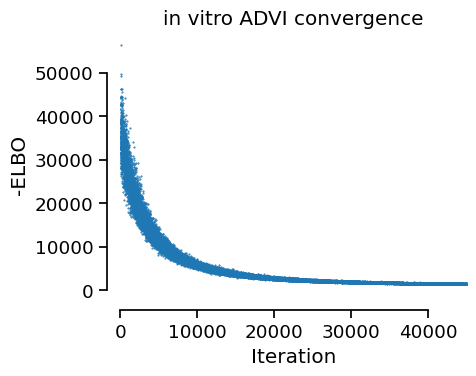

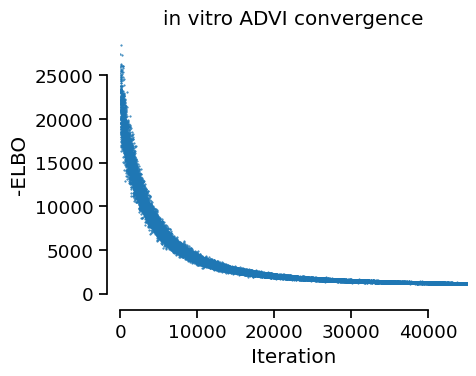

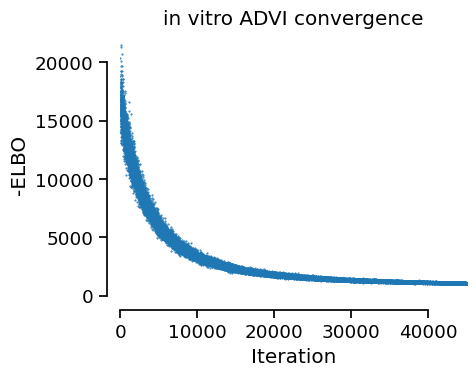

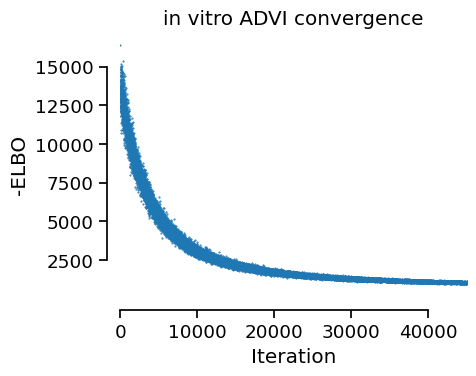

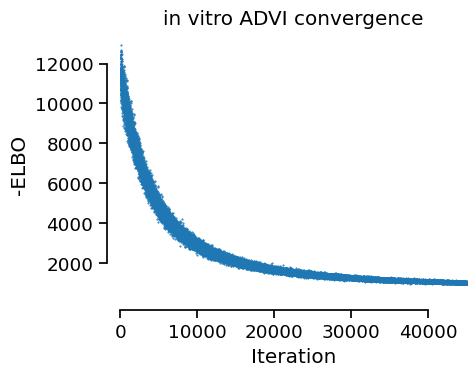

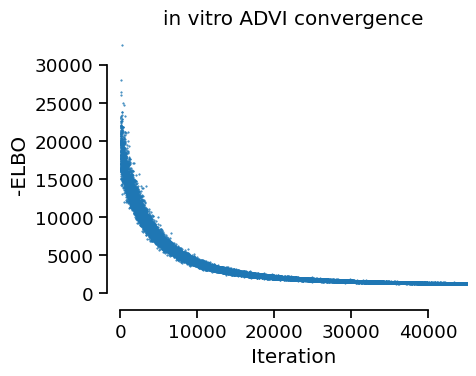

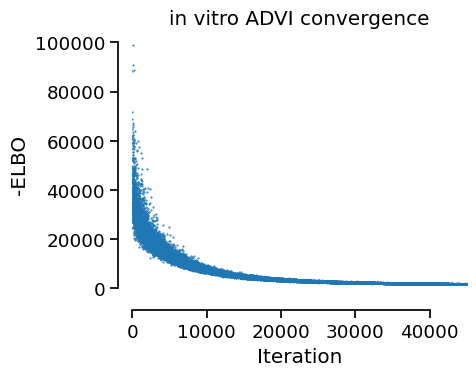

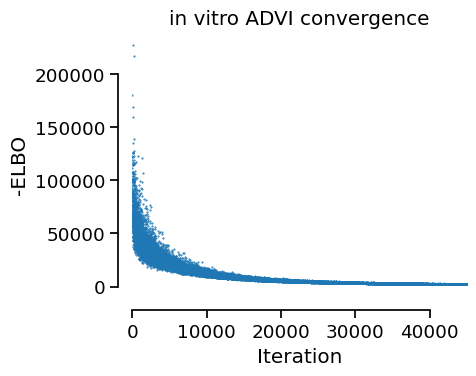

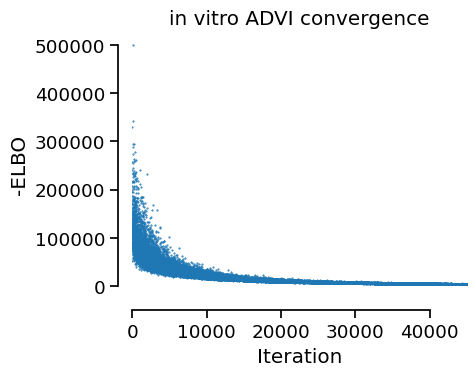

In [ ]:
trace01 = run_ADVI(BMCA_obj01)
trace02 = run_ADVI(BMCA_obj02)
trace03 = run_ADVI(BMCA_obj03)
trace04 = run_ADVI(BMCA_obj04)
trace05 = run_ADVI(BMCA_obj05)

trace15 = run_ADVI(BMCA_obj15)
trace3 = run_ADVI(BMCA_obj3)
trace5 = run_ADVI(BMCA_obj5)
trace7 = run_ADVI(BMCA_obj7)
trace100 = run_ADVI(BMCA_obj100)
# 255 min

### saving trace data

In [10]:
with gzip.open("topologyA-reg1-stronger_allData_traces.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100
                },
                f,
            )

# Analysis

In [8]:
# picklefolder = '../../../data/results/tracePickles-20240718/'
with gzip.open('topologyA-reg1-stronger_allData_traces.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [9]:
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

### Elasticity check

In [10]:
Ex01_advi = util.get_az_summary(trace01)
Ex02_advi = util.get_az_summary(trace02)
Ex03_advi = util.get_az_summary(trace03)
Ex04_advi = util.get_az_summary(trace04)
Ex05_advi = util.get_az_summary(trace05)

Ex15_advi = util.get_az_summary(trace15)
Ex3_advi = util.get_az_summary(trace3)
Ex5_advi = util.get_az_summary(trace5)
Ex7_advi = util.get_az_summary(trace7)
Ex100_advi = util.get_az_summary(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


In [11]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                Ex01_advi, Ex02_advi, Ex03_advi, 
                                Ex04_advi, Ex05_advi,  
                                Ex15_advi, Ex3_advi, Ex5_advi, 
                                Ex7_advi, Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels, 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyA-noReg_allData_elasticities.csv')

In [ ]:
elasticities_df.loc['vOSC_J__']

-3.611654034902593

In [12]:
e_slopes = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

### elasticity graphs

'plt.text(left_adjust, slope_start, "slopes")\nfor i, label in enumerate(pt_labels[0:5]):\n    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f\'{label}: {e_slopes[i]}\')\n\nplt.text(left_adjust, r2_start, \'R-squared\')\nfor i, label in enumerate(pt_labels[0:5]):\n    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f\'{label}: {e_r2s[i]}\')\n\ncolors = [\'tab:blue\', \'tab:orange\', \'tab:green\', \'tab:red\', \'tab:purple\']\nfor i in range(5):\n    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle=\'--\', alpha=0.6, color=colors[i], zorder=0)'

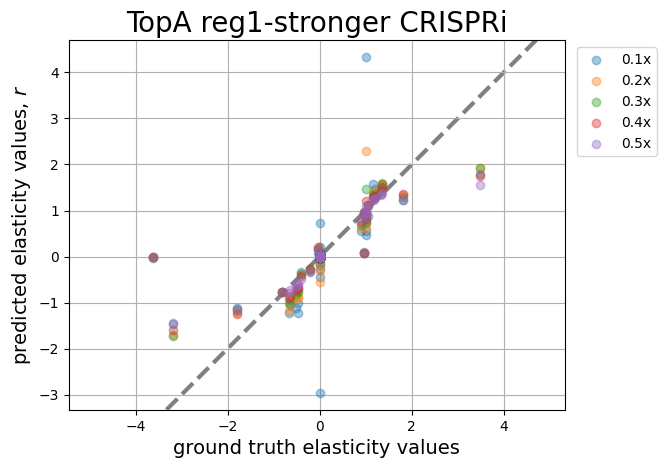

In [ ]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
# plt.scatter(elasticities_df['gt'], elasticities_df['1.01x'], alpha=0.4, label='1.01x', zorder=10)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title('TopA reg1-stronger CRISPRi', size=20)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

left_adjust = 2.8
line_spacing = 0.12
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

"""plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)"""

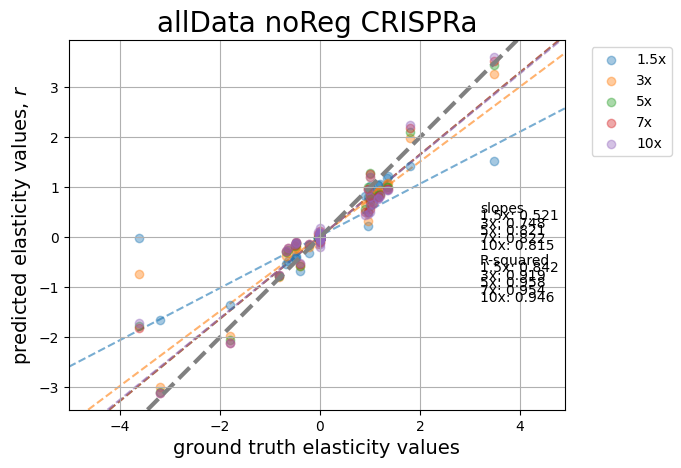

In [14]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
plt.title('allData noReg CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

left_adjust = 3.2
line_spacing = 0.15
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[5:10]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i+5]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[5:10]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i+5]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i+5]), slope=e_slopes[i+5], linestyle='--', alpha=0.6, color=colors[i], zorder=0)

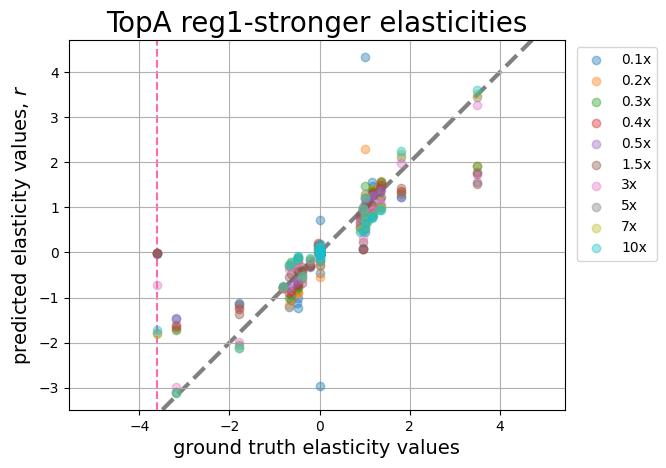

In [76]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x', zorder=10)


plt.axvline(x=elasticities_df.loc['vOSC_J__']['gt'], c='hotpink', linestyle='dashed', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth elasticity values', size=14)
plt.ylabel('predicted elasticity values, $\it{r}$', size=14)
# plt.title('Parity plot of elasticity values for various \nenzyme perturbation strengths—CRISPRi', size=20)
plt.title(f'Top{topology} {omission} elasticities', size=20)
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

left_adjust = 2.8
line_spacing = 0.12
slope_start = 0.5
r2_start = slope_start-(7*line_spacing)

"""plt.text(left_adjust, slope_start, "slopes")
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (slope_start-line_spacing)-(i*line_spacing), f'{label}: {e_slopes[i]}')

plt.text(left_adjust, r2_start, 'R-squared')
for i, label in enumerate(pt_labels[0:5]):
    plt.text(left_adjust, (r2_start-line_spacing)-(i*line_spacing), f'{label}: {e_r2s[i]}')

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
for i in range(5):
    plt.axline((0, e_intercepts[i]), slope=e_slopes[i], linestyle='--', alpha=0.6, color=colors[i], zorder=0)"""

plt.savefig(f'../../../data/results/raw_svg_figures/topA/elasticities/top{topology}-{omission}-elasticities.svg', format="svg")

### ANOVA

In [14]:
# running ANOVA on differences btw gt and predicted
# elasticities_df = elasticities_df.sub(elasticities_df['gt'], axis=0)
stats.f_oneway(elasticities_df['0.1x'],
                elasticities_df['0.2x'],
                elasticities_df['0.3x'],
                elasticities_df['0.4x'],
                elasticities_df['0.5x'],
                elasticities_df['1.5x'],
                elasticities_df['3x'],
                elasticities_df['5x'],
                elasticities_df['7x'],
                elasticities_df['10x'])

F_onewayResult(statistic=0.016063552460353406, pvalue=0.999999866648143)

### MAE

In [15]:
# print out MAE for each perturbation strength
MAE = abs(elasticities_df.sub(elasticities_df['gt'], axis=0)).sum()/len(elasticities_df['gt'])
MAE

gt      0.000000
0.1x    0.066231
0.2x    0.049078
0.3x    0.040410
0.4x    0.033364
0.5x    0.028928
1.5x    0.028071
3x      0.027783
5x      0.036203
7x      0.040976
10x     0.045748
dtype: float64

In [17]:
MAE.to_csv('../../../data/results/MAE/topologyA-reg1_allData_MAE.csv')

Text(0.5, 1.0, 'MAE of elasticity predictions based\non enzyme perturbation strength')

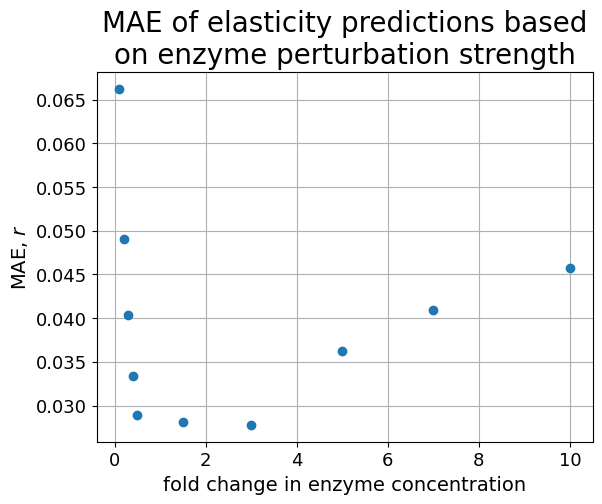

In [19]:
plt.scatter(pt_levels, MAE[1:].values, zorder=10)
plt.grid(True, which='both', axis='both', zorder=0)
# plt.xscale('log')
plt.xlabel('fold change in enzyme concentration', size=14)
plt.ylabel('MAE, $\it{r}$', size=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title("MAE of elasticity predictions based\non enzyme perturbation strength", size=20)

## Calculating control coefficients

In [31]:
Ex01_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj01)['prior']['Ex'])
Ex02_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj02)['prior']['Ex'])
Ex03_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj03)['prior']['Ex'])
Ex04_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj04)['prior']['Ex'])
Ex05_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj05)['prior']['Ex'])

Ex15_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj15)['prior']['Ex'])
Ex3_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj3)['prior']['Ex'])
Ex5_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj5)['prior']['Ex'])
Ex7_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj7)['prior']['Ex'])
Ex100_prior = util.get_az_summary(util.run_prior_predictive(BMCA_obj100)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

## Calculating CCC values and making graphs

In [33]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())

### priors

In [34]:
priorCCC01 = util.estimate_CCCs(BMCA_obj01, Ex01_prior.reshape((16,-1)))
priorCCC02 = util.estimate_CCCs(BMCA_obj02, Ex02_prior.reshape((16,-1)))
priorCCC03 = util.estimate_CCCs(BMCA_obj03, Ex03_prior.reshape((16,-1)))
priorCCC04 = util.estimate_CCCs(BMCA_obj04, Ex04_prior.reshape((16,-1)))
priorCCC05 = util.estimate_CCCs(BMCA_obj05, Ex05_prior.reshape((16,-1)))
priorCCC15 = util.estimate_CCCs(BMCA_obj15, Ex15_prior.reshape((16,-1)))
priorCCC3 = util.estimate_CCCs(BMCA_obj3, Ex3_prior.reshape((16,-1)))
priorCCC5 = util.estimate_CCCs(BMCA_obj5, Ex5_prior.reshape((16,-1)))
priorCCC7 = util.estimate_CCCs(BMCA_obj7, Ex7_prior.reshape((16,-1)))
priorCCC100 = util.estimate_CCCs(BMCA_obj100, Ex100_prior.reshape((16,-1)))

In [35]:
priorCCCs = [priorCCC01, priorCCC02, priorCCC03, priorCCC04, priorCCC05, priorCCC15, priorCCC3, priorCCC5, priorCCC7, priorCCC100]

In [36]:
priorCCC_meds = [-pd.DataFrame(np.median(priorCCC, axis=0), columns=r.getReactionIds(), index=r.getFloatingSpeciesIds()) for priorCCC in priorCCCs]
priorCCC_meds = pd.concat([i.melt()['value'] for i in priorCCC_meds], axis=1).values
priorCCC_meds = pd.DataFrame(priorCCC_meds, columns=pt_labels)
priorCCC_meds['median'] = priorCCC_meds.median(axis=1)
priorCCC_meds['min'] = priorCCC_meds.min(axis=1)
priorCCC_meds['max'] = priorCCC_meds.max(axis=1)
# priorCCC_meds

In [37]:
CCC_lower_y_prior = np.array(priorCCC_meds['median']) - np.array(priorCCC_meds['min'])
CCC_upper_y_prior = np.array(priorCCC_meds['max']) - np.array(priorCCC_meds['median'])
CCC_errors_prior = [CCC_lower_y_prior, CCC_upper_y_prior]

### posteriors

In [38]:
# all data
postCCC01 = util.estimate_CCCs(BMCA_obj01, Ex01_advi.reshape((16, -1)))
postCCC02 = util.estimate_CCCs(BMCA_obj02, Ex02_advi.reshape((16, -1)))
postCCC03 = util.estimate_CCCs(BMCA_obj03, Ex03_advi.reshape((16, -1)))
postCCC04 = util.estimate_CCCs(BMCA_obj04, Ex04_advi.reshape((16, -1)))
postCCC05 = util.estimate_CCCs(BMCA_obj05, Ex05_advi.reshape((16, -1)))
postCCC15 = util.estimate_CCCs(BMCA_obj15, Ex15_advi.reshape((16, -1)))
postCCC3 = util.estimate_CCCs(BMCA_obj3, Ex3_advi.reshape((16, -1)))
postCCC5 = util.estimate_CCCs(BMCA_obj5, Ex5_advi.reshape((16, -1)))
postCCC7 = util.estimate_CCCs(BMCA_obj7, Ex7_advi.reshape((16, -1)))
postCCC100 = util.estimate_CCCs(BMCA_obj100, Ex100_advi.reshape((16, -1)))

In [39]:
postCCCs = [postCCC01, postCCC02, postCCC03, postCCC04, postCCC05, postCCC15, postCCC3, postCCC5, postCCC7, postCCC100]

In [40]:
postCCC_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=r.getReactionIds(), index=r.getFloatingSpeciesIds()) for postCCC in postCCCs]
postCCC_meds = pd.concat([i.melt()['value'] for i in postCCC_meds], axis=1).values
postCCC_meds = pd.DataFrame(postCCC_meds, columns=pt_labels)
postCCC_meds['median'] = postCCC_meds.median(axis=1)
postCCC_meds['min'] = postCCC_meds.min(axis=1)
postCCC_meds['max'] = postCCC_meds.max(axis=1)
# postCCC_meds

In [41]:
CCC_lower_y_post = np.array(postCCC_meds['median']) - np.array(postCCC_meds['min'])
CCC_upper_y_post = np.array(postCCC_meds['max']) - np.array(postCCC_meds['median'])
CCC_errors_post = [CCC_lower_y_post, CCC_upper_y_post]

### CCC graphs

Text(0, 0.5, 'predicted CCC values')

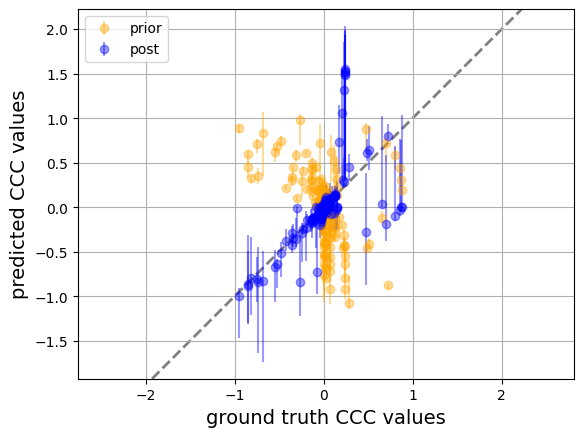

In [42]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC.melt()['value'], priorCCC_meds['median'], yerr=CCC_errors_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC.melt()['value'], postCCC_meds['median'], yerr=CCC_errors_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs.svg', format="svg")

Text(0, 0.5, 'predicted CCC values')

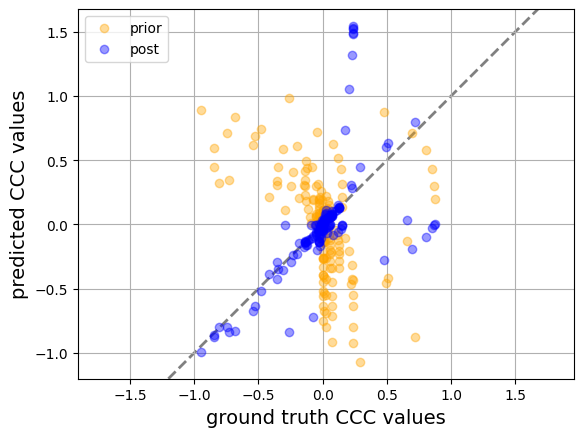

In [47]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC.melt()['value'], priorCCC_meds['median'], alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC.melt()['value'], postCCC_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth CCC values', size=14)
plt.ylabel('predicted CCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs.svg', format="svg")

## Calculating FCCs

In [43]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [44]:
priorFCC01 = util.estimate_FCCs(BMCA_obj01, Ex01_prior.reshape((16,-1)))
priorFCC02 = util.estimate_FCCs(BMCA_obj02, Ex02_prior.reshape((16,-1)))
priorFCC03 = util.estimate_FCCs(BMCA_obj03, Ex03_prior.reshape((16,-1)))
priorFCC04 = util.estimate_FCCs(BMCA_obj04, Ex04_prior.reshape((16,-1)))
priorFCC05 = util.estimate_FCCs(BMCA_obj05, Ex05_prior.reshape((16,-1)))

priorFCC15 = util.estimate_FCCs(BMCA_obj15, Ex15_prior.reshape((16,-1)))
priorFCC3 = util.estimate_FCCs(BMCA_obj3, Ex3_prior.reshape((16,-1)))
priorFCC5 = util.estimate_FCCs(BMCA_obj5, Ex5_prior.reshape((16,-1)))
priorFCC7 = util.estimate_FCCs(BMCA_obj7, Ex7_prior.reshape((16,-1)))
priorFCC100 = util.estimate_FCCs(BMCA_obj100, Ex100_prior.reshape((16,-1)))


In [45]:
postFCC01 = util.estimate_FCCs(BMCA_obj01, Ex01_advi.reshape((16, -1)))
postFCC02 = util.estimate_FCCs(BMCA_obj02, Ex02_advi.reshape((16, -1)))
postFCC03 = util.estimate_FCCs(BMCA_obj03, Ex03_advi.reshape((16, -1)))
postFCC04 = util.estimate_FCCs(BMCA_obj04, Ex04_advi.reshape((16, -1)))
postFCC05 = util.estimate_FCCs(BMCA_obj05, Ex05_advi.reshape((16, -1)))

postFCC15 = util.estimate_FCCs(BMCA_obj15, Ex15_advi.reshape((16, -1)))
postFCC3 = util.estimate_FCCs(BMCA_obj3, Ex3_advi.reshape((16, -1)))
postFCC5 = util.estimate_FCCs(BMCA_obj5, Ex5_advi.reshape((16, -1)))
postFCC7 = util.estimate_FCCs(BMCA_obj7, Ex7_advi.reshape((16, -1)))
postFCC100 = util.estimate_FCCs(BMCA_obj100, Ex100_advi.reshape((16, -1)))

In [46]:
prior_FCCs = [priorFCC01, priorFCC02, priorFCC03, priorFCC04, priorFCC05, priorFCC15, priorFCC3, priorFCC5, priorFCC7, priorFCC100]
post_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]


In [ ]:
priorFCC_meds = [-pd.DataFrame(np.median(priorFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for priorFCC in prior_FCCs]
priorFCC_meds = pd.concat([i.melt()['value'] for i in priorFCC_meds], axis=1).values
priorFCC_meds = pd.DataFrame(priorFCC_meds, columns=pt_labels)
priorFCC_meds['median'] = priorFCC_meds.median(axis=1)
priorFCC_meds['min'] = priorFCC_meds.min(axis=1)
priorFCC_meds['max'] = priorFCC_meds.max(axis=1)
# priorFCC_meds

FCC_lower_y_prior = np.array(priorFCC_meds['median']) - np.array(priorFCC_meds['min'])
FCC_upper_y_prior = np.array(priorFCC_meds['max']) - np.array(priorFCC_meds['median'])
FCC_errors_prior = [FCC_lower_y_prior, FCC_upper_y_prior]

In [ ]:
postFCC_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for postFCC in post_FCCs]
postFCC_meds = pd.concat([i.melt()['value'] for i in postFCC_meds], axis=1).values
postFCC_meds = pd.DataFrame(postFCC_meds, columns=pt_labels)
postFCC_meds['median'] = postFCC_meds.median(axis=1)
postFCC_meds['min'] = postFCC_meds.min(axis=1)
postFCC_meds['max'] = postFCC_meds.max(axis=1)
# postFCC_meds

FCC_lower_y_post = np.array(postFCC_meds['median']) - np.array(postFCC_meds['min'])
FCC_upper_y_post = np.array(postFCC_meds['max']) - np.array(postFCC_meds['median'])
FCC_errors_post = [FCC_lower_y_post, FCC_upper_y_post]

## FCC graphs

Text(0, 0.5, 'predicted FCC values')

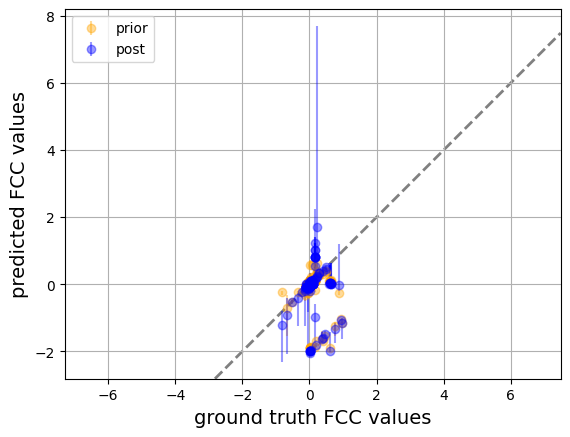

In [ ]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_meds['median'], yerr=FCC_errors_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], yerr=FCC_errors_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs.svg', format="svg")

Text(0, 0.5, 'predicted FCC values')

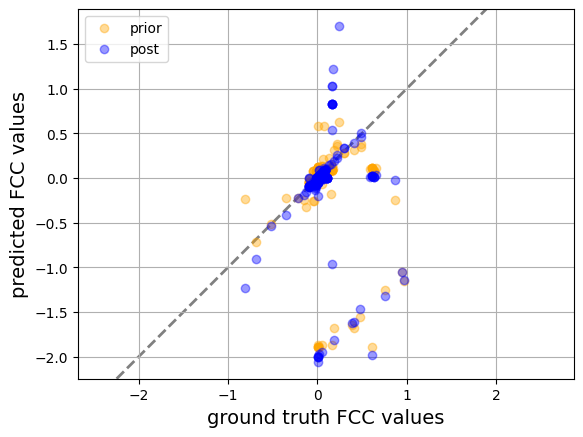

In [ ]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_meds['median'], alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs.svg', format="svg")

### adding corrections for where the enzyme perturbed is directly involved in the reaction

In [26]:
rxn = np.repeat(r.getReactionIds(),len(r.getReactionIds()))
enz_pt = r.getReactionIds() * len(r.getReactionIds())
FCC_idx = pd.DataFrame([rxn, enz_pt]).T

In [27]:
pt_enz_is_rxn = np.linspace(0,len(rxn)-1,len(r.getReactionIds()))
pt_enz_is_rxn

array([  0.,  17.,  34.,  51.,  68.,  85., 102., 119., 136., 153., 170.,
       187., 204., 221., 238., 255.])

### graphing the corrected FCC dfs

In [ ]:
priorFCC_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_meds.loc[pt_enz_is_rxn, 'median'] += 2

Text(0, 0.5, 'predicted FCC values')

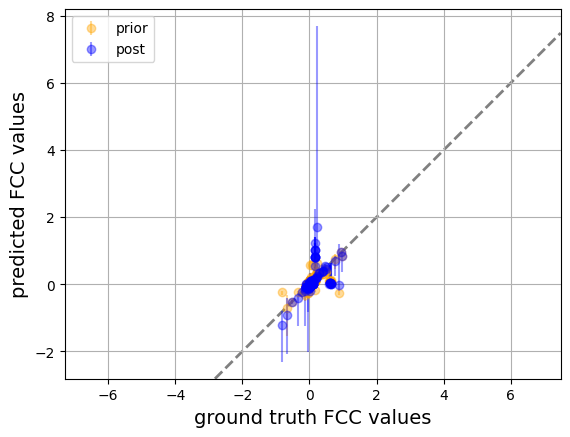

In [ ]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_meds['median'], yerr=FCC_errors_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], yerr=FCC_errors_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_wCorrection.svg', format="svg")

Text(0, 0.5, 'predicted FCC values')

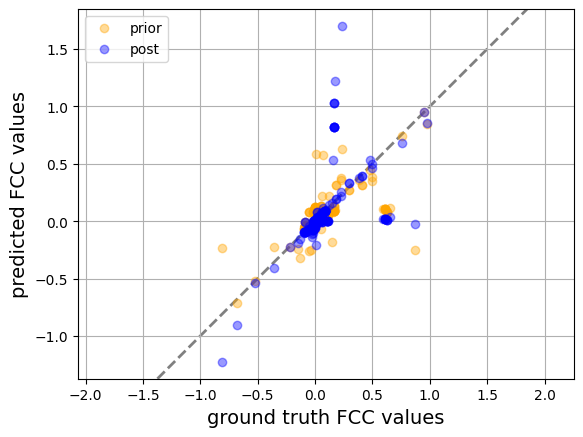

In [ ]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_meds['median'], alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('ground truth FCC values', size=14)
plt.ylabel('predicted FCC values', size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_wCorrection.svg', format="svg")

## Evaluating FCC ranking

In [25]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')

a = gtFCC_rankings.loc['vYAN']

### via Spearman rank coefficients

In [26]:
spearman_coefficients = []
p_values = []
confidence_intervals = []
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'vYAN', r)
    b_list.append(b)
    spearman_r, p_value, lower_ci, upper_ci = util.bootstrap_spearman(a.dropna(), b.dropna())
    spearman_coefficients.append(spearman_r)
    p_values.append(p_value)
    confidence_intervals.append((lower_ci, upper_ci))


In [27]:
pt_labels = [i+'-prior' for i in pt_labels] + [i+'-post' for i in pt_labels]

In [28]:
spearman_df = pd.DataFrame(spearman_coefficients, columns=['r'], index=pt_labels)
spearman_df['p-value'] = p_values
spearman_df['lower'] = [i[0] for i in confidence_intervals]
spearman_df['upper'] = [i[1] for i in confidence_intervals]
spearman_df

,r,p-value,lower,upper
0.1x-prior,0.375000,0.168433,-0.271772,0.827539
0.2x-prior,0.260714,0.347979,-0.502992,0.768891
0.3x-prior,0.310714,0.259667,-0.403526,0.796210
0.4x-prior,0.092857,0.742045,-0.525389,0.666458
0.5x-prior,0.207143,0.458843,-0.505594,0.752829
1.5x-prior,0.025000,0.929529,-0.612481,0.590500
3x-prior,0.046429,0.869492,-0.646081,0.603797
5x-prior,0.035714,0.899447,-0.583905,0.608713
7x-prior,-0.064286,0.819948,-0.717993,0.522634
10x-prior,-0.035714,0.899447,-0.691665,0.557900


In [29]:
spearman_df.to_csv('../../../data/results/spearman_coefficients/topologyA-reg1_allData_spr.csv')

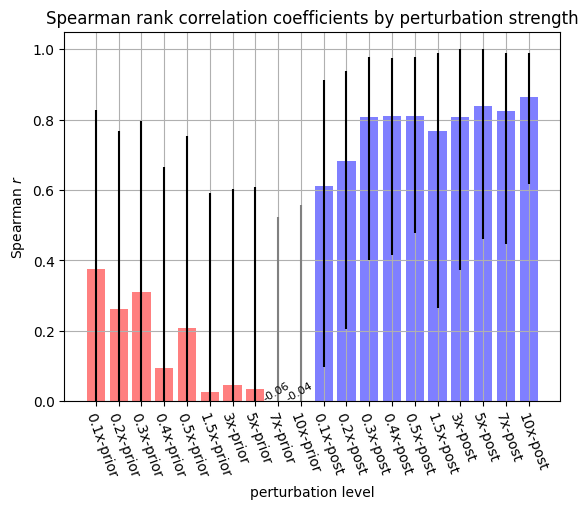

In [46]:
plt.bar(pt_labels, [i for i in spearman_coefficients], alpha=0.5, color=['r']*10 + ['b']*10)
plt.grid()

for i, val in enumerate(spearman_df['r']):
    if val < 0: 
        c ='gray'
    else: 
        c='k'
    plt.vlines(pt_labels[i], spearman_df['lower'][i], spearman_df['upper'][i], color=c)

for i, val in enumerate(spearman_df['r']):
    if val < 0: 
        plt.annotate(round(val, 2), (pt_labels[i], 0.02), size=8, ha='center', rotation=30,rotation_mode="anchor")

plt.title("Spearman rank correlation coefficients by perturbation strength")
plt.xlabel('perturbation level')
plt.ylabel('Spearman $\it{r}$')
plt.ylim((0, 1.05))

_=plt.xticks(rotation=-70,ha='left',rotation_mode="anchor")

### evaluating top 10 rankings

In [31]:
b_list = []
for FCC in prior_FCCs + post_FCCs:
    b = util.calculate_FCC_med_rankings(FCC, 'vYAN', r)
    b_list.append(b)

ranked_b_list = [b.sort_values().reset_index().set_index('vYAN') for b in b_list]
q = pd.concat(ranked_b_list, axis=1)
q['gt'] = a.sort_values().reset_index().set_index('vYAN')
q.columns = pt_labels + ['gt']
q = q[['gt'] + pt_labels]
q.head(15) ## top 15 table

,gt,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,...,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
vYAN,,,,,,,,,,,,,,,,,,,,,
1.0,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,...,vOSC,vOSC,vOSC,vOSC,vOSC,vOSC,vWHI,vWHI,vWHI,vWHI
2.0,vOSC,vOSC,vOSC,vUNI,vSIE,vVIC,vQUE,vUNI,vROM,vSIE,...,vWHI,vWHI,vWHI,vWHI,vWHI,vWHI,vOSC,vALP,vALP,vALP
3.0,vVIC,vQUE,vQUE,vVIC,vQUE,vUNI,vSIE,vSIE,vSIE,vTAN,...,vNOV,vALP,vALP,vALP,vALP,vLIM,vALP,vOSC,vLIM,vLIM
4.0,vALP,vUNI,vUNI,vOSC,vTAN,vTAN,vTAN,vQUE,vTAN,vROM,...,vZUL,vNOV,vNOV,vNOV,vNOV,vALP,vLIM,vLIM,vNOV,vNOV
5.0,vLIM,vNOV,vTAN,vQUE,vUNI,vQUE,vUNI,vVIC,vQUE,vUNI,...,vALP,vZUL,vZUL,vLIM,vLIM,vQUE,vNOV,vNOV,vOSC,vOSC
6.0,vNOV,vTAN,vSIE,vTAN,vROM,vSIE,vROM,vROM,vUNI,vQUE,...,vKIL,vKIL,vKIL,vZUL,vKIL,vNOV,vQUE,vQUE,vPAP,vPAP
7.0,vQUE,vSIE,vROM,vSIE,vOSC,vROM,vVIC,vPAP,vVIC,vPAP,...,vQUE,vQUE,vLIM,vQUE,vZUL,vPAP,vPAP,vPAP,vQUE,vQUE
8.0,vKIL,vALP,vVIC,vROM,vVIC,vOSC,vPAP,vTAN,vPAP,vVIC,...,vLIM,vUNI,vQUE,vKIL,vQUE,vZUL,vROM,vKIL,vKIL,vVIC
9.0,vZUL,vKIL,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM,vLIM,...,vUNI,vLIM,vROM,vROM,vROM,vKIL,vKIL,vZUL,vZUL,vKIL


In [32]:
q.to_csv('../../../data/results/rankings/topologyA-reg1_allData_rankings.csv')
rank_df = pd.read_csv('../../../data/results/rankings/topologyA-reg1_allData_rankings.csv')

In [33]:
topTen_df = rank_df[rank_df['vYAN'].isin([1,2,3,4,5,6,7,8,9,10])]

gt_t10_set = set(list(topTen_df['gt']))

t10_sets = []
for pt in pt_labels: 
    t10_sets.append(set(list(topTen_df[pt])))

t10_scores=[]
for i in t10_sets: 
    t10_scores.append(len(set.intersection(gt_t10_set, i)))

t10_results = pd.DataFrame((np.array(t10_scores)).reshape((len(pt_labels),-1)).T, 
             columns=pt_labels)
t10_results ## number of correct predictions of top 10 FCC values 

,0.1x-prior,0.2x-prior,0.3x-prior,0.4x-prior,0.5x-prior,1.5x-prior,3x-prior,5x-prior,7x-prior,10x-prior,0.1x-post,0.2x-post,0.3x-post,0.4x-post,0.5x-post,1.5x-post,3x-post,5x-post,7x-post,10x-post
0,7,6,6,6,6,6,6,6,6,6,9,9,9,9,9,9,9,9,9,9


In [34]:
# difference
dif_list = []
for i in t10_sets: 
    dif_list.append(i.difference(gt_t10_set))

for i in dif_list: 
    print(rank_df['gt'].loc[lambda x: x.isin(i)].index)

Int64Index([11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([10, 11, 12, 13], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([13], dtype='int64')
Int64Index([11], dtype='int64')
Int64Index([11], dtype='int64')
Int64Index([11], dtype='int64')
Int64Index([10], dtype='int64')
Int64Index([10], dtype='int64')
Int64Index([10], dtype='int64')
Int64Index([10], dtype='int64')
Int64Index([10], dtype='int64')
